In [46]:
from datascience import *
import numpy as np
import pandas as pd
from math import *
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

## Lesson 35: Regression

Over the last two lessons, you went over regression in Data 8.3x. In these sections, you learned how to calculate the slope and intercept of a line fit to a bivariate sample. For example, using the `baby.csv` dataset, you can use regression to predict birthweight given the gestational age of the baby at birth. 

### Exercise 1

Find the least squares line that predicts birthweight based on the gestational age of a baby. You should use `minimize`, an optimization method in the `datascience` package. Note that you could use standardization (similar to what they did in Data 8.3x, `lec7.ipynb`) but the resulting intercept and slope would be in standardized units, and would need to be transformed in order to be interpretable. 

In [47]:
baby = Table.read_table('Data/baby.csv')
baby.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


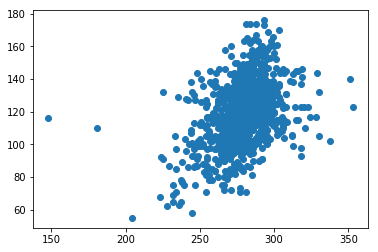

In [48]:
plt.scatter(baby.column(1),baby.column(0))
plt.show()

In [49]:
def errors(t, slope, intercept):
    errors = t.column(0) - (t.column(1)*slope + intercept)
    return errors

In [50]:
#From lab 3....
def fit_line(tbl):
    # Your code may need more than 1 line below here.
    # Rather than using the regression line formulas, try
    # calling minimize on the mean squared error.
    def mse(any_slope,any_intercept):
        y = tbl.column(0)
        x = tbl.column(1)
        fitted = any_slope*x + any_intercept
        mse = np.mean((y - fitted) ** 2)
        return mse        
    slope = minimize(mse)[0]
    intercept = minimize(mse)[1]
    return make_array(slope,intercept)

In [51]:
fit_line(baby)

array([ 0.4284037 , -0.07039869])

In the context of the data, interpret the intercept and slope. 

The intercept is the wieght of the baby at conception is negative so it doesn't really tell us anything. The slope is the weight gained per day. 

The slope is 0.428. It seems reasonable to expect this slope to be significantly higher than zero; it makes sense that gestational age would impact birthweight. Let's check using bootstrapping. 

[0.42480764 0.4322389 ]


C:\Users\C20Pierce.Pluemer\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


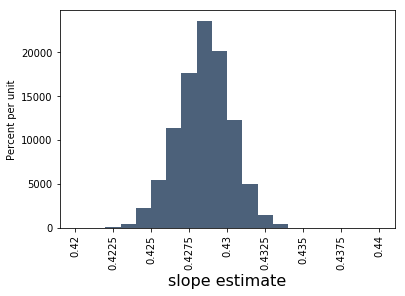

In [52]:
bootstrap_slope = make_array()
for i in np.arange(1000):
    test = fit_line(baby.sample())
    bootstrap_slope = np.append(bootstrap_slope, test.item(0))
    
    
    
print(percentile([2.5,97.5],bootstrap_slope))    
    
Table().with_column("slope estimate", bootstrap_slope).hist(bins=np.arange(0.42, 0.44, .001))    

Note that zero does not appear and the interval is really small. Large sample size means a smaller confidence interval. 


### Exercise 2

For a baby born at 40 weeks gestational age, what do we expect to be the average birthweight according to this model?

In [53]:
fit_line(baby).item(0) * (40*7) -fit_line(baby).item(1)

120.02343453384697

Using bootstrapping, build a 95% confidence interval around this estimate. Interpret this interval, carefully. 

In [54]:
temp = make_array()
for i in np.arange(1000):
    temp_table = baby.sample()
    test = fit_line(temp_table).item(0) * (40*7) -fit_line(temp_table).item(1)
    temp = np.append(temp, test)
    
    
print(percentile(2.5, temp))
print(percentile(97.5,temp))

119.0617519137718
121.08383143151151


This is a confidence inteval on the **mean** birthweight for a baby born at 40 weeks. 

### Exercise 3

Suppose a baby is born at 40 weeks. Let's construct a confidence interval for the birthweight of *that baby*. This is different than the confidence interval on the mean birthweight of babies born at 40 weeks. This interval is known as a prediction interval. 

A simple way to find the prediction interval is to sample many times (with replacement) from the observed residuals and add to the predicted birthweight under the linear model. Find the percentiles of these simulations to obtain the interval. 

Had to look at solution to understand what the quesiton was asking. 

In [55]:
line = fit_line(baby)
line

array([ 0.4284037 , -0.07039869])

In [56]:
residulals = errors(baby,line.item(0),line.item(1))
residulals

array([ -1.59625195,  -7.73944455,   8.54576655, ...,   5.40492215,
         4.68895915, -10.16550004])

In [57]:
def predict(coef,value):
    return (value*coef[0] + coef[1])

In [58]:
bootstrap_pred_weight = make_array()

for i in np.arange(1000):
    bootstrap_pred_weight = np.append(bootstrap_pred_weight,np.sqrt((predict(fit_line(baby.sample()),280))**2+
                                      (np.random.choice(residulals,size=1))**2))

In [60]:
bootstrap_pred_weight = make_array()

for i in np.arange(1000):
    bootstrap_pred_weight = np.append(bootstrap_pred_weight,predict(fit_line(baby.sample()),150)+
                                      np.random.choice(residulals,size=1))

In [61]:
lower_end = np.percentile(bootstrap_pred_weight,2.5)
upper_end = np.percentile(bootstrap_pred_weight,97.5)
print("95% confidence interval for the predicted weight at 40 weeks: [{:g}, {:g}]".format(lower_end, upper_end))

95% confidence interval for the predicted weight at 40 weeks: [29.8544, 97.2866]


It turns out that this method is a little oversimplified. A "more correct" method is below. This requires taking into account the *leverage* of each data point (basically a measure of impact to the model of each data point). 

In [63]:
def mse_resample(any_slope,any_intercept):
    x=resample.column(1)
    y=resample.column(0)
    predicted = any_slope*x+any_intercept
    return np.mean((y-predicted)**2)

In [64]:
residuals=baby.column(0)-(intercept+slope*baby.column(1))

slope = 0.4284037 
intercept = -0.07039869

pred=intercept+slope*150
leverage=1/baby.num_rows + ((baby.column(1)-np.mean(baby.column(1)))**2)/np.sum(((baby.column(1)-np.mean(baby.column(1)))**2))
adjresiduals=residuals/np.sqrt(1-leverage)

bs_all=[]
for _ in np.arange(5000):
    bs_y=(intercept+slope*baby.column(1))+np.random.choice(adjresiduals,size=baby.num_rows,replace=True)
    resample=Table().with_columns("y",bs_y,"x",baby.column(1))
    bs_slope,bs_intercept=minimize(mse_resample)
    bs_residuals=bs_y-(bs_intercept+bs_slope*baby.column(1))
    bs_adjresiduals=bs_residuals/np.sqrt(1-leverage)
    bs_all=np.append(bs_all,150*(slope-bs_slope)+np.random.choice(bs_adjresiduals))

percentile([2.5,97.5],pred+bs_all)

array([30.3590275, 97.3787985])